In [72]:
import itertools
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform, jaccard
from scipy.stats import spearmanr

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

feat = pd.read_csv("../data/zeo-features.csv", index_col=0)

## Hierarchical clustering

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, homogeneity_score

In [4]:
Z = linkage(squareform(dm.values), method='ward')

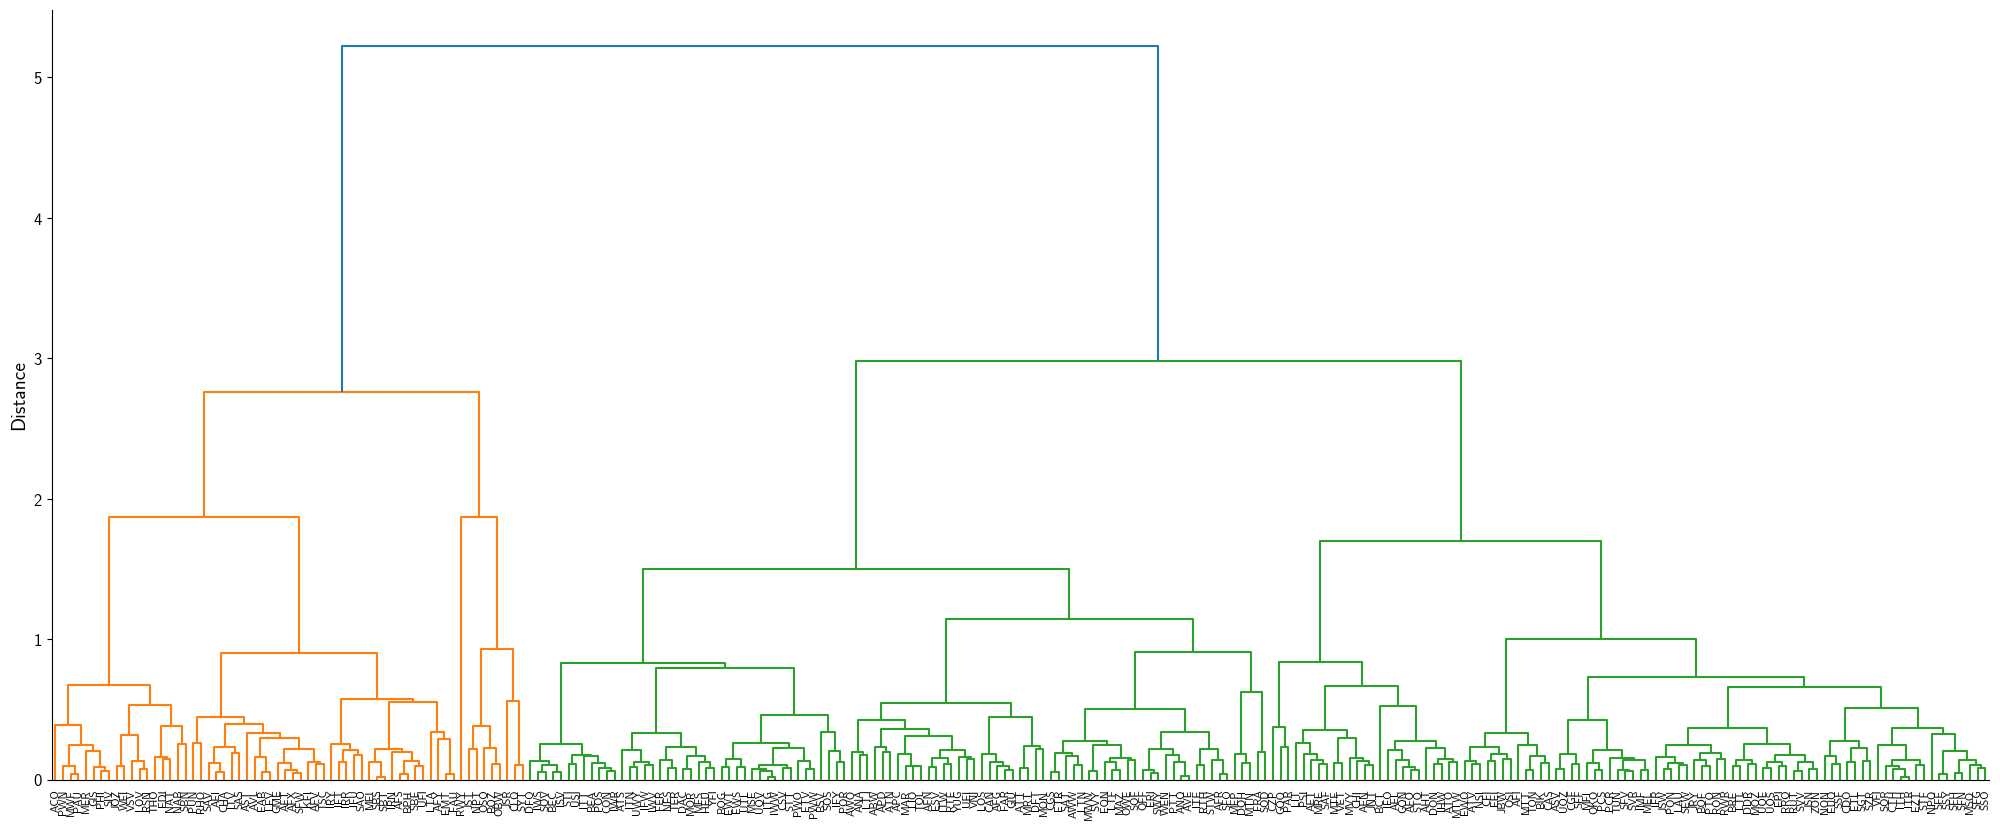

In [5]:
# %matplotlib notebook
fig, ax = plt.subplots(figsize=(25, 10))

dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

xticks = [int(t.get_text()) for t in ax.get_xticklabels()]

ax.set_xticklabels([dm.columns[i] for i in xticks])
ax.set_ylabel('Distance')

# fig.savefig("dendrogram.pdf", bbox_inches="tight")
plt.show()

## Quantifying degree of clustering

In [6]:
def get_positive_clusters(true_labels, clusters):
    df = pd.DataFrame([true_labels, clusters], index=["label", "cluster"]).T
    
    grp = df.groupby("cluster")["label"]
    positive = grp.count()[(grp.sum() > 0)]
    idx = positive.loc[positive > 1].index
    
    df = df.loc[df.cluster.isin(idx)]
    
    return df["label"].values, df["cluster"].values
    
def recall_homogeneity(true_labels, clusters):
    """Computes the homogeneity of a given clustering by:
    
        1. Selecting only the clusters with at least one positive label
        2. Computing the homogeneity per cluster
        3. Normalizing the homogeneity for all clusters
    
    Arguments:
        true_labels (list): true binary labels
        clusters (list): assigned clusters
    """
    
    df = pd.DataFrame([true_labels, clusters], index=["label", "cluster"]).T
    
    # select clusters larger than 2 with at least one positive label
    grp = df.groupby("cluster")["label"]
    positive = grp.count()[(grp.sum() > 0)]
    good_clusters = positive.loc[positive > 1].index
    
    df = df.loc[df.cluster.isin(good_clusters)]
    
    if len(df) == 0:
        return np.nan
    
    # compute the homogeneity on a per-cluster basis
    grp = df.groupby("cluster")
    H = grp.mean()
    min_score = 1 / grp.count()
    
    norm_H = (H - min_score) / (1 - min_score)
    
    return norm_H.mean().item()

In [7]:
SYN_THRESHOLD = 0.25
THRESHOLDS = np.concatenate([
    np.arange(0.1, 1, 0.01),
    np.arange(1, 3.5, 0.1),
])
    
results = []
for threshold in THRESHOLDS:
    clusters = fcluster(Z, threshold, criterion='distance')
    
    for condition in synth.columns:
        labels = (synth[condition] > SYN_THRESHOLD).astype(int)

        _l, _c = get_positive_clusters(labels.values, clusters)
        
        results.append({
            "threshold": threshold,
#             condition: recall_homogeneity(labels.values, clusters),
            condition: homogeneity_score(_l, _c)
        })

df = pd.DataFrame(results)
df = df.groupby("threshold").first()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


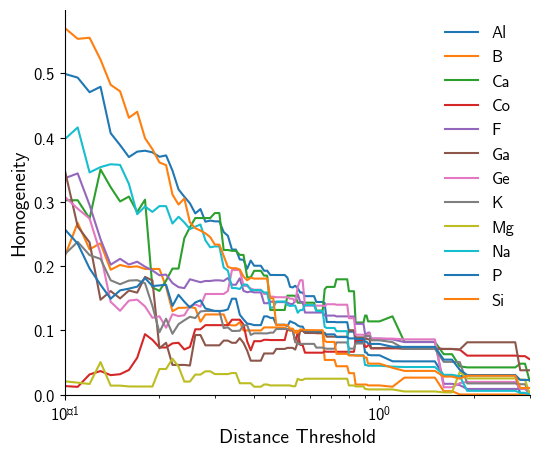

In [42]:
fig, ax = plt.subplots(figsize=(6, 5))

_LABELS = ["Al", "B", "Ca", "Co", "F", "Ga", "Ge", "K", "Mg", "Na", "P", "Si"]

for label in _LABELS:
    
    ax.plot(
        df.index,
        df[label],
        label=label,
    )

ax.set_xlabel("Distance Threshold")
ax.set_ylabel("Homogeneity")

ax.legend(frameon=False)

ax.set_xlim(0.1, 3)
ax.set_ylim(0)

ax.set_xscale("log")

# fig.tight_layout()

plt.show()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


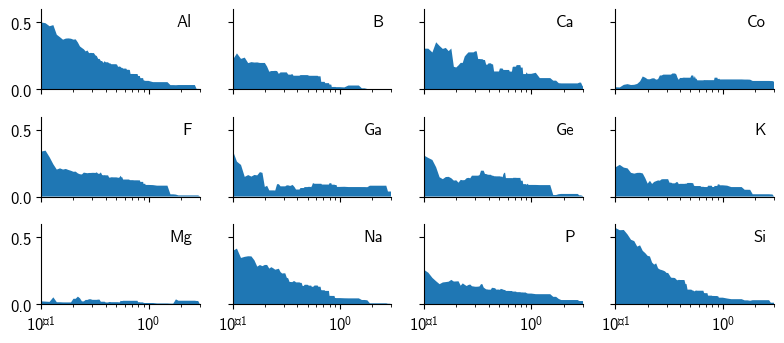

In [70]:
LX, LY = 2, 1.2
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

_LABELS = ["Al", "B", "Ca", "Co", "F", "Ga", "Ge", "K", "Mg", "Na", "P", "Si"]

for ax, label in zip(ax_fig.reshape(-1), _LABELS):
    ax.fill_between(
        df.index,
        df[label],
        label=label,
    )
    ax.set_xlim(0.1, 3)
    ax.set_ylim(0, 0.6)
    ax.set_xscale("log")
    ax.annotate(label, (0.95, 0.85), xycoords='axes fraction', ha="right", va="center")

# for ax in ax_fig[-1, :]:
#     ax.set_xlabel("Distance Threshold")

# for ax in ax_fig[:, 0]:
#     ax.set_ylabel("Homogeneity")

fig.tight_layout()

plt.show()

## Highlighting the graph based on the synthesis conditions

In [79]:
with open("../data/iza-mst.pkl", "rb") as f:
    G = pickle.load(f)

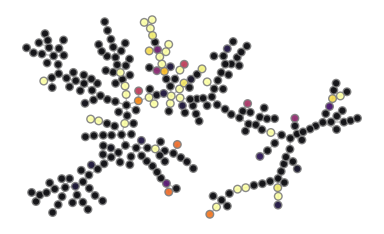

In [81]:
fig, ax = plt.subplots(figsize=(4, 2.5))

pos = nx.get_node_attributes(G, "pos")

options = {
    "edgecolors": "tab:gray",
    "node_size": 30,
    "alpha": 0.9,
    "cmap": "inferno",
    "vmin": 0,
    "vmax": 1,
}

nx.draw_networkx_nodes(G, pos, node_color=synth["Ge"], **options)

for i, j in G.edges:
    xy = np.stack([pos[i], pos[j]])
    ax.plot(xy[:, 0], xy[:, 1], linewidth=1.0, color="#808080", alpha=0.5, zorder=-1)

# labels = nx.get_node_attributes(G, 'zeo') 
# nx.draw_networkx_labels(G, pos, labels, font_size=6)

plt.tight_layout()
plt.axis("off")

# fig.savefig("iza-tmap.pdf", bbox_inches="tight", transparent=True)
plt.show()

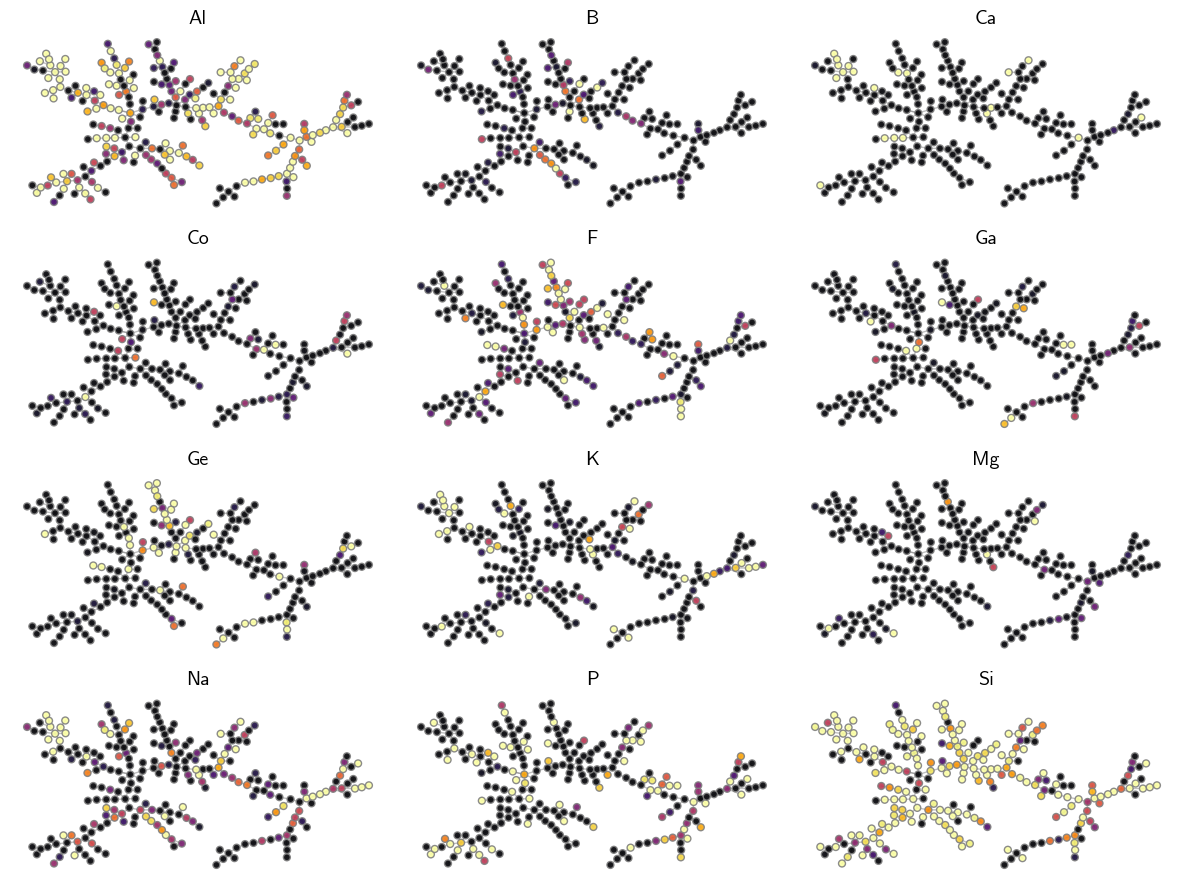

In [83]:
L = 3
fig, ax_fig = plt.subplots(4, 3, figsize=(4 * L, 3 * L))

pos = nx.get_node_attributes(G, "pos")

options = {
    "edgecolors": "tab:gray",
    "node_size": 25,
    "alpha": 0.9,
    "cmap": "inferno",
    "vmin": 0,
    "vmax": 1,
}

for ax, label in zip(ax_fig.reshape(-1), _LABELS):
    nx.draw_networkx_nodes(G, pos, node_color=synth[label], ax=ax, **options)

    for i, j in G.edges:
        xy = np.stack([pos[i], pos[j]])
        ax.plot(xy[:, 0], xy[:, 1], linewidth=1.0, color="#808080", alpha=0.5, zorder=-1)
    
    ax.axis("off")
    ax.set_title(label)

plt.tight_layout()

# fig.savefig("iza-tmap.pdf", bbox_inches="tight", transparent=True)
plt.show()